In [73]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import pickle
%matplotlib inline

### Loading the data

In [2]:
with open('US.pkl', 'rb') as file:
    df = pickle.load(file)

In [3]:
df.head()

,video_id,trending_date,publish_time,channel_title,category_id,category_name,title,description,tags,views,likes,dislikes,comment_count,days_since_last_trend
0,2kyS6SvSYSE,2017-11-14,2017-11-13 17:13:01,CaseyNeistat,22,People & Blogs,WE WANT TO TALK ABOUT OUR MARRIAGE,SHANTELL'S CHANNEL - https://www.youtube.com/s...,SHANtell martin,748374,57527,2966,15954,0 days
1,1ZAPwfrtAFY,2017-11-14,2017-11-13 07:30:00,LastWeekTonight,24,Entertainment,The Trump Presidency: Last Week Tonight with J...,"One year after the presidential election, John...","last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,0 days
2,5qpjK5DgCt4,2017-11-14,2017-11-12 19:05:24,Rudy Mancuso,23,Comedy,"Racist Superman | Rudy Mancuso, King Bach & Le...",WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,0 days
3,puqaWrEC7tY,2017-11-14,2017-11-13 11:00:04,Good Mythical Morning,24,Entertainment,Nickelback Lyrics: Real or Fake?,Today we find out if Link is a Nickelback amat...,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,0 days
4,d380meD0W0M,2017-11-14,2017-11-12 18:01:41,nigahiga,24,Entertainment,I Dare You: GOING BALD!?,I know it's been a while since we did this sho...,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,0 days


In [4]:
df.dtypes

video_id                          object
trending_date             datetime64[ns]
publish_time              datetime64[ns]
channel_title                     object
category_id                        int64
category_name                     object
title                             object
description                       object
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
days_since_last_trend    timedelta64[ns]
dtype: object

### Basic statistical analysis

In [5]:
df.describe()

,category_id,views,likes,dislikes,comment_count,days_since_last_trend
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04,40949
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03,0 days 21:26:57.534005714
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04,0 days 17:19:49.476896780
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02,1 days 00:00:00
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03,1 days 00:00:00
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03,1 days 00:00:00
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,26 days 00:00:00


Let us examine how correlated the numerical columns are - views, likes, dislikes, comment_count

<AxesSubplot:>

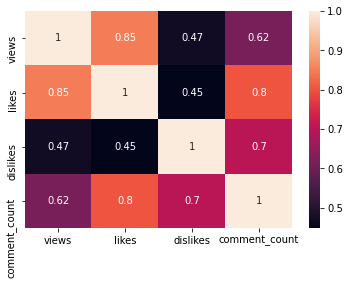

In [6]:
sns.heatmap(df[['views', 'likes', 'dislikes', 'comment_count']].corr(), annot=True)

We see that the correlation between pairs of columns varies, but overall they are all very high. The correlation between views and likes, especially, is very high (0.85), and the correlation between likes and the number of comments a video gets is also very high (0.8). This makes sense since people can end up liking videos they've watched dozens of times, and when people like videos they are more prone to commenting and professing their interest in it to others. It is interesting that views and dislikes has a much lower correlation - I would have thought that the greater the views of a video, the greater the number of people disliking it as well.

This is useful information to obtain, since when we build a model and engineer features it is important for there to not be any redundancy or multicollinearity since this can mess with the performance of the model.

In [7]:
df[df['views'] == df['views'].max()][['category_name', 'views']]

,category_name,views
38547,Music,225211923


In [8]:
df[df['likes'] == df['likes'].max()][['category_name', 'likes']]

,category_name,likes
38273,Music,5613827


Since the likes and views columns were highly correlated, it makes sense that Music is the category with both the highest number of views and likes. Now let us see if the same video and creator get the highest number of views and likes.

In [9]:
df[df['views'] == df['views'].max()][['title', 'views', 'channel_title']]

,title,views,channel_title
38547,Childish Gambino - This Is America (Official V...,225211923,ChildishGambinoVEVO


In [10]:
df[df['likes'] == df['likes'].max()][['title', 'likes', 'channel_title']]

,title,likes,channel_title
38273,BTS (방탄소년단) 'FAKE LOVE' Official MV,5613827,ibighit


This is interesting - they are two separate videos, both by different creators, but are both music videos.

In [11]:
df[df['dislikes'] == df['dislikes'].max()][['title', 'views', 'dislikes', 'channel_title']]

,title,views,dislikes,channel_title
11323,So Sorry.,37539570,1674420,Logan Paul Vlogs


I remember when Logan Paul put out his terrible apology video and the internet proceeded to 'cancel' him from the zeitgeist, so I can see how his video has the largest number of dislikes.

I want to see if the numerical features are normally distributed or not, and if they are not then I will log-transform them.

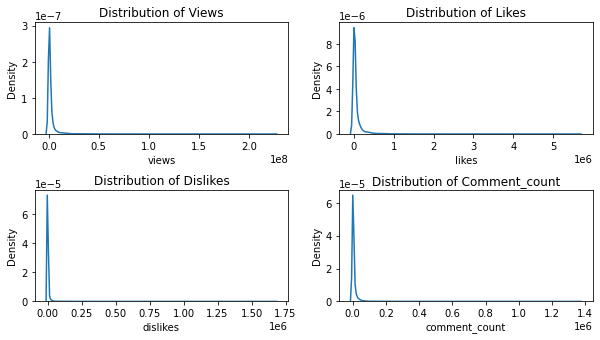

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(221)
a = sns.kdeplot(df['views'])
a.set_title('Distribution of Views')

plt.subplot(222)
b = sns.kdeplot(df['likes'])
b.set_title('Distribution of Likes')

plt.subplot(223)
c = sns.kdeplot(df['dislikes'])
c.set_title('Distribution of Dislikes')

plt.subplot(224)
d = sns.kdeplot(df['comment_count'])
d.set_title('Distribution of Comment_count')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5,top = 0.9)

I decided to use kernel density estimate plots instead of histograms since KDE can produce plots that are more interpretable and less cluttered (https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot). All the distributions look exponential/skewed. I will transform them into normally distributed variables so that they are easier to work with and understand.

In [13]:
df['views_log'] = np.log(df['views'])
df['likes_log'] = np.log(df['likes'] + 1)
df['comments_log'] = np.log(df['comment_count'] + 1)
df['dislikes_log'] = np.log(df['dislikes'] + 1)

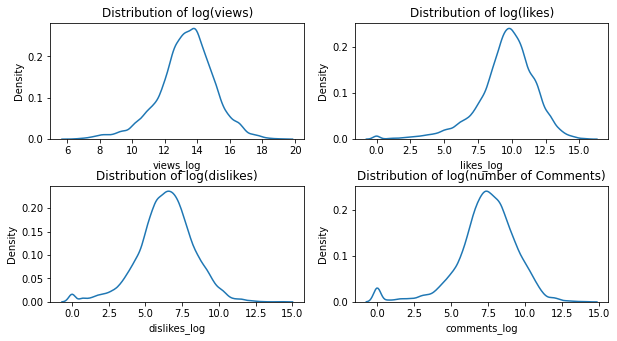

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(221)
a = sns.kdeplot(df['views_log'])
a.set_title('Distribution of log(views)')

plt.subplot(222)
b = sns.kdeplot(df['likes_log'])
b.set_title('Distribution of log(likes)')

plt.subplot(223)
c = sns.kdeplot(df['dislikes_log'])
c.set_title('Distribution of log(dislikes)')

plt.subplot(224)
d = sns.kdeplot(df['comments_log'])
d.set_title('Distribution of log(number of Comments)')

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

We see that all the numeric columns look normally distributed, which is good. Mission accomplished!

When I just tried taking the log transforms of the columns and not the log(column_value + 1), I was unable to plot the distribution since the range of the function went down to below -1 which the function refused to plot.

Like we did before, let us look at the correlation of the numeric variables, but this time we will use the log transformed ones.

<AxesSubplot:>

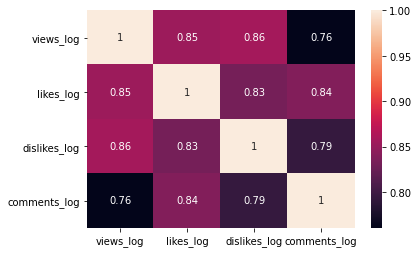

In [15]:
sns.heatmap(df[['views_log', 'likes_log', 'dislikes_log', 'comments_log']].corr(), annot=True)

Overall, the correlation between pairs of numeric variables has increased ever since we log transformed them. This makes sense since nonlinear transformations either increase or decrease the linear relationship between variables which alters their correlation as well.

Let us create a few more columns to emphasize the rate of viewer engagement, simce simply viewing the number of likes, dislikes, and comments doesn't tell us enough since we do not know how many people even happened upon the video in the first place. Hence, I am going to create three more columns - like rate, comment rate, and dislike rate - in order to really understand how viewers are engaging with videos in different categories.

In [16]:
df['like_rate'] = df['likes']/df['views']
df['dislike_rate'] = df['dislikes']/df['views']
df['comment_rate'] = df['comment_count']/df['views']

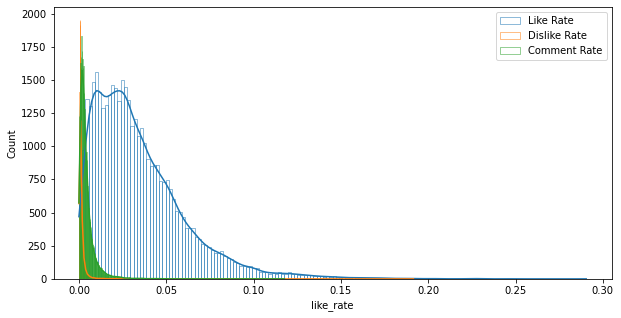

In [17]:
plt.figure(figsize=(10,5))

sns.histplot(df['like_rate'], label='Like Rate', fill=False, kde=True)
sns.histplot(df['dislike_rate'], label = 'Dislike Rate', fill=False, kde=True)
sns.histplot(df['comment_rate'], label= 'Comment Rate', fill=False,kde=True)
plt.legend()

In [18]:
max(df['dislike_rate'])

0.19153148343449283

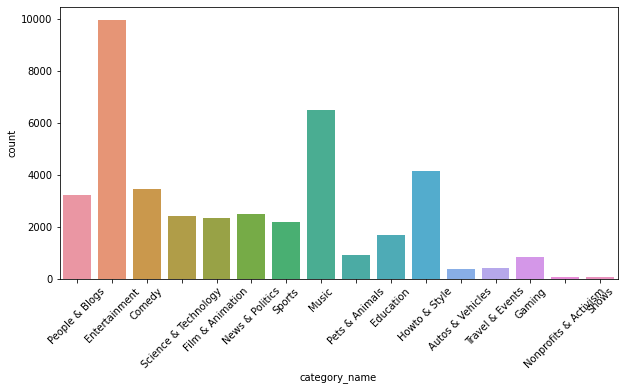

In [19]:
plt.figure(figsize=(10,5))
p = sns.countplot(x='category_name', data=df)
p.set_xticklabels(labels = p.get_xticklabels(), rotation=45);

The most popular categories is Entertainment, Music, and How-to & Style. 

Let us see the distribution of comments across the various categories. What category of video are viewers most likely to comment on?

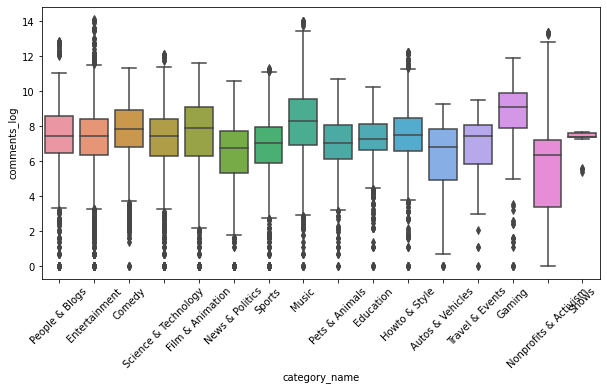

In [20]:
plt.figure(figsize=(10,5))
p = sns.boxplot(x='category_name', y='comments_log', data=df)
p.set_xticklabels(p.get_xticklabels(), rotation=45);

We see that there is a wide range in videos in terms of how many comments a specific category will get. There are many outliers for all the categories, particularly Entertainment. Shows seems to be a weird category with a small range of comments. Let us examine this category.

In [21]:
df[df['category_name'] == 'Shows']['channel_title'].value_counts()

Bleacher Report    41
CNET               16
Name: channel_title, dtype: int64

We see that there are only two unique possible channels that make videos that fit into the Shows category. Shows also has the smallest number of videos in the dataset (as seen in the graph above).

Let us also look the distribution of likes across the various categories to understand viewer engagement.

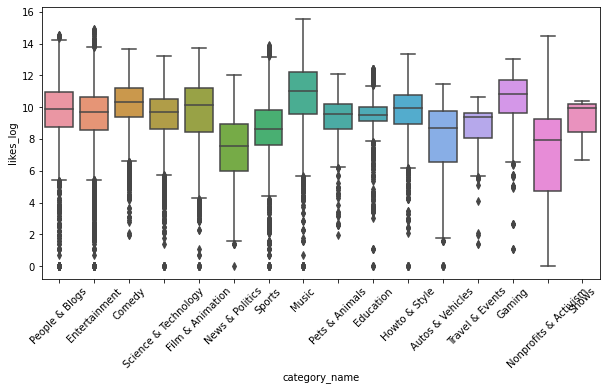

In [22]:
plt.figure(figsize=(10,5))
p = sns.boxplot(x='category_name', y='likes_log', data=df)
p.set_xticklabels(p.get_xticklabels(), rotation=45);

We see that the inter-quartile range of the log(likes) of Non-profits and Activism is the largest, and the mean likes(log) of News & Politics and Non-profits & Activism is the lowest.

### Examining the trending & publishing dates

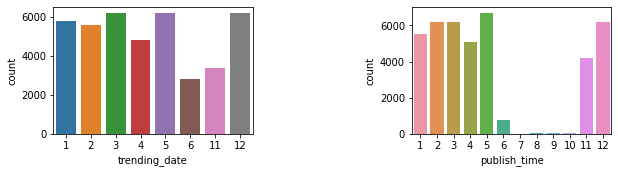

In [31]:
plt.figure(figsize=(10,5))

plt.subplot(221)
sns.countplot(x=df['trending_date'].dt.month)

plt.subplot(222)
sns.countplot(x=df['publish_time'].dt.month)

plt.subplots_adjust(wspace = 0.8, top = 0.9)

This makes sense, since our data only contains videos that trended between November 2017 and June 2018. We see a high number of trending videos in March, May, and December. Obviously, this comparison is unfair to November and June since only half the videos that trended in those months were included, so it is hard to say what the true number of trending videos in those months are.

It's interesting that the number of videos published in months 7 through 10 is very small as well. This can mean that either there is some anomaly that we can explore or that, most of the time, a video trends right after it has been published, indicating that videos that trend between November and June are mostly published between November and June as well.

<AxesSubplot:xlabel='trending_date', ylabel='like_rate'>

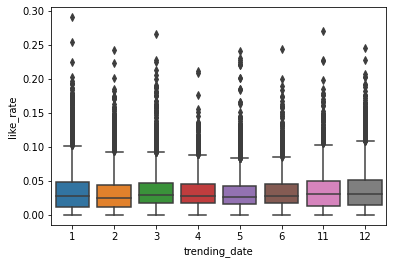

In [32]:
sns.boxplot(x=df['trending_date'].dt.month, y=df['like_rate'])

Let us count the number of videos that trend per hour in a day.

<AxesSubplot:xlabel='publish_time', ylabel='count'>

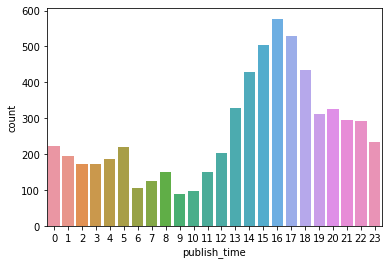

In [44]:
sns.countplot(x=df.drop_duplicates(subset=['video_id'], keep='first')['publish_time'].dt.hour)

I isolated only the unique video_ids since I wanted to get a good picture of when videos were published without weighting it by the number of times a certain video trended.

This is interesting! Most videos seem to be published after 1 PM, with a peak between 2 PM and 6 PM.

Now that we have examined the numeric and date featurs, let us make some word clouds to examine the titles, descriptions, and tags of the videos in our dataset.

(-0.5, 399.5, 199.5, -0.5)

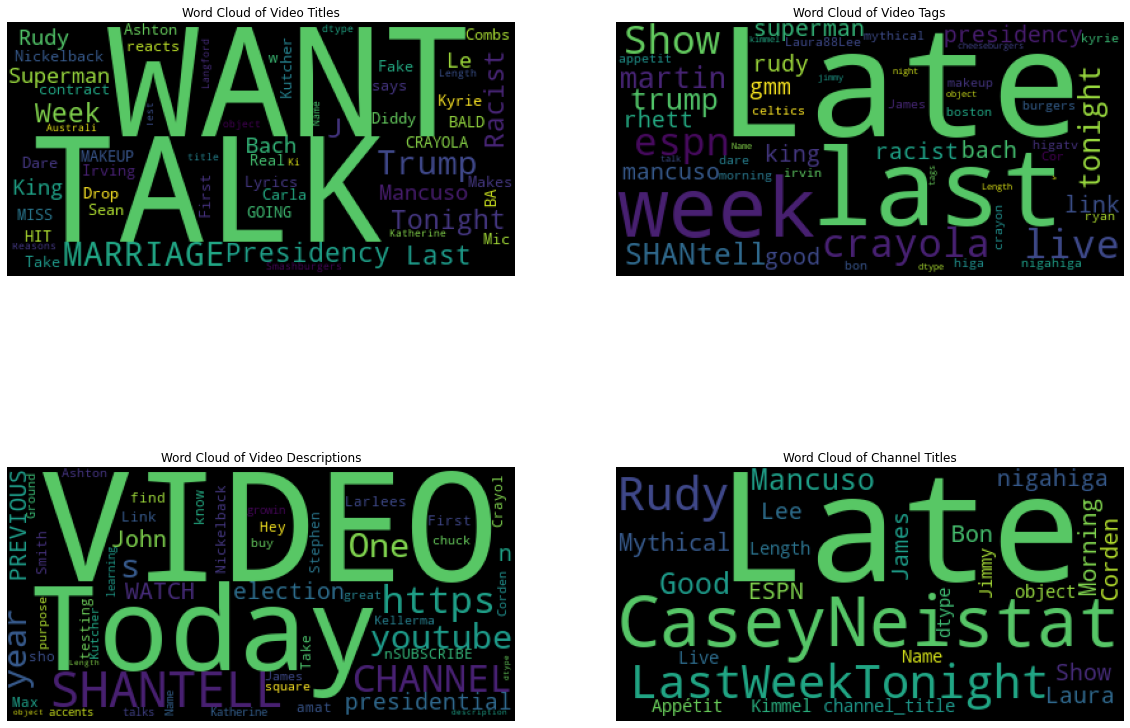

In [61]:
plt.figure(figsize = (20,15))

stopwords = set(STOPWORDS)

plt.subplot(221)
wordcloud1 = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(df.drop_duplicates(subset=['video_id'], keep='first')['title']))

plt.imshow(wordcloud1)
plt.title("Word Cloud of Video Titles")
plt.axis('off')

plt.subplot(222)
wordcloud2 = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(df.drop_duplicates(subset=['video_id'], keep='first')['tags']))

plt.imshow(wordcloud2)
plt.title("Word Cloud of Video Tags")
plt.axis('off')

plt.subplot(223)
wordcloud3 = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(df.drop_duplicates(subset=['video_id'], keep='first')['description']))

plt.imshow(wordcloud3)
plt.title("Word Cloud of Video Descriptions")
plt.axis('off')

plt.subplot(224)
wordcloud4 = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(df.drop_duplicates(subset=['video_id'], keep='first')['channel_title']))

plt.imshow(wordcloud4)
plt.title("Word Cloud of Channel Titles")
plt.axis('off')

In [74]:
file = open('dataframe_after_EDA.pkl','wb')

pickle.dump(df, file)
file.close()